# Limpieza de datos

Vamos a aplicar el [checklist del Banco Mundial](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning) en Python usando el [SciPy stack](https://www.scipy.org/stackspec.html), principalmente pandas

## 0. Prerequisitos

Aclaración: La próxima celda es para compatilibidad con Colab, NO ES RECOMENDADO realizar pip install desde un notebook.

In [92]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  BASE_DIR = "https://github.com/DiploDatos/AnalisisYCuracion/raw/master/"
else:
  BASE_DIR = ".."
if 'ftfy' not in sys.modules:
    !pip install 'ftfy<5.6'

# 1. Importando los datos

# 1.1. Verificar que no hay problemas en la importación

In [93]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

Veamos de importar datos de proyectos de Kickstarter la plataforma de Crowdsourcing

In [94]:
import os
BASE_DIR = os.getcwd()

kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")

FileNotFoundError: [Errno 2] File b'/home/malopez/dev/diplo/AnalisisYCuracion/notebooks/input/kickstarter-projects/ks-projects-201612.csv' does not exist: b'/home/malopez/dev/diplo/AnalisisYCuracion/notebooks/input/kickstarter-projects/ks-projects-201612.csv'

Por defecto Pandas falla si hay errores para leer datos https://pandas.pydata.org/pandas-docs/stable/io.html#error-handling

Por ahora cambiamos a un archivo más actualizado, volveremos a este error más adelante

In [ ]:
import os
BASE_DIR = os.getcwd()
kickstarter_2018 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201801.csv")

Veamos los datos cargados en el dataframe

In [ ]:
kickstarter_2018

Por defecto solo vemos los valores al comienzo o al final del archivo.

Tomemos una muestra al azar para ver valores más dispersos

In [ ]:
# set seed for reproducibility
import numpy as np
np.random.seed(0)

In [ ]:
kickstarter_2018.sample(5)

No se observa a simple vista ningún problema obvio.

Notar que todos vimos los mismos resultados. Al fijar la semilla no hubo tal azar, esto es algo necesario cuando queremos "reproducir valores aleatorios"

Veamos la descripción del dataset si se corresponde con lo levantado https://www.kaggle.com/kemical/kickstarter-projects/data

In [95]:
pd.DataFrame([["ID", "No description provided", "Numeric"],
["name", "No description provided", "String"],
["category", "No description provided", "String"],
["main_category", "No description provided", "String"],
["currency", "No description provided", "String"],
["deadline", "No description provided", "DateTime"],
["goal", "Goal amount in project currency", "Numeric"],
["launched", "No description provided", "DateTime"],
["pledged", "Pledged amount in the project currency", "Numeric"],
["state", "No description provided", "String"],
["backers", "No description provided", "Numeric"],
["country", "No description provided", "String"],
["usd pledged", "Pledged amount in USD (conversion made by KS)", "Numeric"],
["usd_pledged_real", "Pledged amount in USD (conversion made by fixer.io api)", "Numeric"],
["usd_goal_real", "Goal amount in USD", "Numeric"]], columns=["Field name","Field description", "Type"])

,Field name,Field description,Type
0,ID,No description provided,Numeric
1,name,No description provided,String
2,category,No description provided,String
3,main_category,No description provided,String
4,currency,No description provided,String
5,deadline,No description provided,DateTime
6,goal,Goal amount in project currency,Numeric
7,launched,No description provided,DateTime
8,pledged,Pledged amount in the project currency,Numeric
9,state,No description provided,String


Ahora veamos los tipos de datos que detectó pandas

In [96]:
kickstarter_2018.dtypes

name                        object
category                    object
main_category                int64
currency                     int64
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
name_weirdness               int64
dtype: object

Los campos object generalmente son String, entonces parece que no reconoció como fechas en **deadline** y **launched** :(

Veamos los datos un resumen de los datos

In [97]:
kickstarter_2018.describe()

,main_category,currency,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
count,378661.00,378661.00,378661.00,378661.00,378661.00,374864.00,378661.00,378661.00,378661.00
mean,7.51,11.00,49080.79,9682.98,105.62,7036.73,9058.92,45454.40,-0.02
std,3.90,3.94,1183391.26,95636.01,907.19,78639.75,90973.34,1152950.06,0.15
min,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,-13.00
25%,5.00,13.00,2000.00,30.00,2.00,16.98,31.00,2000.00,0.00
50%,7.00,13.00,5200.00,620.00,12.00,394.72,624.33,5500.00,0.00
75%,10.00,13.00,16000.00,4076.00,56.00,3034.09,4050.00,15500.00,0.00
max,14.00,13.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71,4.00


Por defecto se ven los datos numéricos, veamos el resto.

In [98]:
kickstarter_2018.describe(include=['object'])

,name,category,state,country
count,378657,378661,378661,378661
unique,375764,159,6,23
top,New EP/Music Development,Product Design,failed,US
freq,41,22314,197719,292627


Operemos un cacho sobre los datos de lanzamiento

In [99]:
kickstarter_2018['launched'].min()

Timestamp('1970-01-01 01:00:00')

Parece funcionar, pero ahora calculemos el rango de fechas de los proyectos

In [100]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()

Timedelta('17533 days 14:02:31')

Indiquemos que columnas son fechas como indica la [documentación](https://pandas.pydata.org/pandas-docs/stable/io.html#datetime-handling)

In [101]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"])
kickstarter_2018.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Ahora vemos que esas columnas fueron reconocidas como fechas

Veamos la misma muestra de nuevo

In [102]:
kickstarter_2018.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
338862,796196901,10G Christmas Tree,Art,Art,USD,2010-12-26,10526.00,2010-12-08 08:44:04,0.00,failed,0,US,0.00,0.00,10526.00
277871,483825010,Gliff,Gaming Hardware,Games,USD,2016-03-28,10000.00,2016-01-28 04:56:18,51.00,failed,5,US,51.00,51.00,10000.00
47000,123916947,STUFFED Food Truck,Food Trucks,Food,USD,2015-01-06,60000.00,2014-11-07 02:24:36,25.00,failed,1,US,25.00,25.00,60000.00
111338,1565733636,NeoExodus Adventure: Origin of Man for Pathfin...,Tabletop Games,Games,USD,2012-05-01,500.00,2012-03-15 01:16:10,585.00,successful,17,US,585.00,585.00,500.00
53743,1273544891,NAPOLEON IN NEW YORK! an original TV Series,Comedy,Film & Video,USD,2016-07-26,25000.00,2016-05-27 00:07:25,25.00,failed,1,US,25.00,25.00,25000.00


Y veamos el resumen de los datos

In [103]:
kickstarter_2018.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,nan,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,nan,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,nan,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,nan,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,nan,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,1074731191.99,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,619086204.32,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,5971.00,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,538263516.00,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


Podemos ver que tenemos primero y último en el resumen de las columnas de fechas.

Ahora deberíamos poder calcular el rango de fechas de lanzamietos

In [104]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()

Timedelta('17533 days 14:02:31')

# 1.2. Asegurar de tener ids/claves únicas

Chequear que no hay datos duplicados

In [105]:
kickstarter_2018.shape

(378661, 15)

Pandas soporta índices en los DataFrames vamos a recargar el conjunto de datos

In [142]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"],
                               index_col=['ID'])

In [121]:
kickstarter_2018.count()

name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

In [122]:
kickstarter_2018.shape

(378661, 14)

De esta forma podemos buscar por el índice

In [123]:
kickstarter_2018.loc[999988282]

name                Nou Renmen Ayiti!  We Love Haiti!
category                              Performance Art
main_category                                     Art
currency                                          USD
deadline                          2011-08-16 00:00:00
goal                                          2000.00
launched                          2011-07-19 09:07:47
pledged                                        524.00
state                                          failed
backers                                            17
country                                            US
usd pledged                                    524.00
usd_pledged_real                               524.00
usd_goal_real                                 2000.00
Name: 999988282, dtype: object

También podemos verificar si hay filas de contenidos duplicado

In [124]:
kickstarter_2018[kickstarter_2018.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


Como Pandas acepta valores duplicados en los índices también debemos verificar ahí

In [125]:
pd.Series(kickstarter_2018.index,dtype=str).describe()

count         378661
unique        378661
top       1914492382
freq               1
Name: ID, dtype: object

In [126]:
kickstarter_2018[kickstarter_2018.index.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


Repasamos con un ejemplo de juguete

In [127]:
csv='1,2\n3,3\n1,3'
print(csv)

1,2
3,3
1,3


In [128]:
from io import StringIO
df = pd.read_csv(StringIO(csv), names=['id','value'], index_col='id')
df

,value
id,
1,2
3,3
1,3


In [129]:
df[df.duplicated()]

,value
id,
1,3


In [130]:
df[df.index.duplicated(keep=False)]

,value
id,
1,2
1,3


#### Ejercicio 1:

Armar una tabla con todos los proyectos con nombres duplicados, ordenados para revisar agrupados. 

In [131]:
kickstarter_2018[kickstarter_2018["name"].fillna("").str.strip().duplicated(keep=False)].count()

name                5136
category            5140
main_category       5140
currency            5140
deadline            5140
goal                5140
launched            5140
pledged             5140
state               5140
backers             5140
country             5140
usd pledged         5036
usd_pledged_real    5140
usd_goal_real       5140
dtype: int64

# 1.3. Despersonalizar datos y guardarlos en un nuevo archivo

Hay muuuchas técnicas para despersonalizar datos.

Para ilustrar mostramos las ofrecidas por Google https://cloud.google.com/dlp/docs/transformations-reference:

* **Reemplazo**: Reemplaza cada valor de entrada con un valor determinado.
* **Ocultamiento**: Quita un valor y lo oculta.
* **Enmascaramiento con caracteres**: Enmascara una string por completo o parcialmente mediante el reemplazo de un número determinado de caracteres con un carácter fijo especificado..
* **Seudonimización mediante el reemplazo de un valor de entrada con un hash criptográfico**: Reemplaza valores de entrada con una string hexadecimal de 32 bytes mediante una clave de encriptación de datos.
* **Cambio de fechas**: Cambia las fechas por un número de días al azar, con la opción de ser coherente en el mismo contexto..
* **Seudonimización mediante el reemplazo con token de preservación de formato criptográfico**: Reemplaza un valor de entrada con un token, o valor sustituto, de la misma longitud mediante la encriptación de preservación de formato (FPE) con el modo de operación FFX. Esto permite que se use el resultado en sistemas con validación de formato o que necesitan aparecer como reales a pesar de que la información no se revela.
* **Valores de depósito con base en rangos de tamaño fijos**: Enmascara los valores de entrada y los reemplaza por depósitos, o rangos dentro de los cuales se encuentra el valor de entrada.
* **Valores de depósito con base en rangos de tamaño personalizados**: Valores de entrada de depósito con base en rangos configurables por el usuario y valores de reemplazo.
* **Extracción de datos de tiempo**: EExtrae o preserva una porción de los valores Date, Timestamp y TimeOfDay.

In [132]:
from hashlib import md5

In [133]:
kickstarter_2018['name'].apply(md5)

TypeError: Unicode-objects must be encoded before hashing

In [134]:
def hashit(val):
    return md5(val.encode('utf-8'))

kickstarter_2018['name'].apply(hashit)

AttributeError: 'float' object has no attribute 'encode'

In [ ]:
def hashit(val):
    try:
        return md5(val.encode('utf-8'))
    except Exception as e:
        print(val, type(val))
        raise(e)

kickstarter_2018['name'].apply(hashit)

In [135]:
from hashlib import md5
def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()


kickstarter_2018['name'] = kickstarter_2018['name'].fillna("").str.strip().apply(hashit)


#### Ejercicio 2:

Verificar que los proyectos que tienen nombres duplicados también tienen el hash de nombre duplicado

In [136]:
kickstarter_2018[kickstarter_2018["name"].fillna("").str.strip().duplicated(keep=False)].count()

name                5140
category            5140
main_category       5140
currency            5140
deadline            5140
goal                5140
launched            5140
pledged             5140
state               5140
backers             5140
country             5140
usd pledged         5036
usd_pledged_real    5140
usd_goal_real       5140
dtype: int64

# 1.4. Nunca modificar los datos crudos u originales


In [ ]:
if not in_colab:
  kickstarter_2018.to_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv")


# 2. Pasos necesarios


In [ ]:
in_colab = False
#import pandas as pd
if not in_colab:
  kickstarter_2018 = pd.read_csv(BASE_DIR + "/../output/ks-projects-201801-for-pandas.csv",
                        index_col='ID',
                        parse_dates=['deadline','launched'])

In [ ]:
kickstarter_2018.describe(include='all')

## 2.1. Etiquetas de variables/columnas: no usar caracteres especiales



In [143]:
# helpful character encoding module
import chardet

¿Por qué? Por que aun hay limitaciones para trabajar con estos caracteres.

¿Cúales son los caracteres "normales"? 

In [144]:
import string

string.ascii_letters + string.digits

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

¿Qué es ASCII? Es una de las primeras codificaciones (o encoding) disponibles. Ver https://en.wikipedia.org/wiki/ASCII

Un encoding es un mapa de caracteres a una representación en bits (por ejemplo 1000001). ASCII es uno de los primeros estandares para interoperatividad entre computadoras (antes cada fabricante de computadora usa su propia codificación), contempla sólo los caracteres ingleses y usa 7 bits, por ejemplo *1000001* codifica el caracter *A*

Cómo sólo representaban los caracteres ingleses, empiezan a aparecer variantes para distintos idiomas, Microsoft hizo los propios para internacionalizar Windows, hubo otro estandar ISO 8859, hasta que llegó el éstandar Unicode que hizo múltiples encodings pero cada uno contempla múltiples idiomas e incluso es extensible a futuro. UTF-8 es de esos encodings el más utilizado. Ver https://en.wikipedia.org/wiki/Unicode

En particular, Python 3 utiliza UTF-8 por defecto (lo que no sucedía en Python 2).

Veamos un ejemplo práctico

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

In [ ]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors = "replace")

# check the type
type(after)

In [ ]:
# take a look at what the bytes look like
after

In [ ]:
# convert it back to utf-8
print(after.decode("utf-8"))

In [ ]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

Este error ya lo vimos...

In [ ]:
kickstarter_2016 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201612.csv")

El error `UnicodeDecodeError` nos indica que el archivo no estaría en Unicode. Si no está en algún metadato o no fue indicado es dificil detectar el encoding, por suerte hay un paquete para esto en Python, que aplica unas heurísticas para detectar encoding.

In [ ]:
# In Colab we need to download data locally
in_colab = False
if in_colab:
  !wget -c $BASE_DIR/input/kickstarter-projects/ks-projects-201612.csv
  DOWN_DIR = "./"
else:
  DOWN_DIR = BASE_DIR + "/../input/kickstarter-projects/"
  
# look at the first ten thousand bytes to guess the character encoding
with open(DOWN_DIR + "/ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
result

Entonces le podemos indicar el encoding al leer el archivos

In [ ]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

Hay otro problema con los caracteres que es más sutíl: **[Mojibake](https://en.wikipedia.org/wiki/Mojibake)**

Sucede al leer UTF-8 como ASCII extendido (ie. `Windows-*`, `iso-8859-*` entre otros)

Ejemplo de mojibake:

In [ ]:
"cigüeña".encode('utf-8').decode('iso-8859-1')

Para esto vamos a usar un módulo específico [ftfy](https://ftfy.readthedocs.io/en/latest/). 

Que nos permite ordenar cadenas por rareza

In [145]:
import ftfy.badness as bad

In [146]:
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)


kickstarter_2018['name_weirdness'] = kickstarter_2018['name'].apply(weird)
kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1221990593,Support PMCD´s ¨From a Different Clay¨,Dance,Dance,USD,2011-06-08,1500.00,2011-04-28 05:15:32,1940.00,successful,27,US,1940.00,1940.00,1500.00,3
1234089244,Cracking (Mastering) the Metaphor (Political)...,Nonfiction,Publishing,USD,2013-10-27,30000.00,2013-09-27 23:33:29,0.00,failed,0,US,0.00,0.00,30000.00,2
124795481,µGALE (Canceled),Wearables,Technology,EUR,2015-04-17,18000.00,2015-02-16 01:55:34,10.00,canceled,2,NL,11.39,10.81,19465.14,2
1468489999,µCurrent GOLD - Precision Multimeter Current A...,Hardware,Technology,AUD,2013-12-31,9900.00,2013-12-17 10:28:09,116575.17,successful,1268,AU,104343.69,104871.51,8906.08,2
1610503461,µPeek - The Professional Microscope that Fits ...,Technology,Technology,CHF,2016-01-09,125000.00,2015-12-10 10:08:18,247688.14,successful,1435,CH,249249.19,246848.85,124576.44,2
16174550,PARALELO 19 Nº,Photography,Photography,MXN,2017-04-15,15000.00,2017-03-01 00:00:24,3340.00,failed,8,MX,0.00,177.36,796.52,2
1719215256,Kickstarter Gold: Manual Coffeemaker Nº3,Product Design,Design,USD,2017-07-22,60000.00,2017-06-20 15:29:56,68587.33,successful,618,US,21002.00,68587.33,60000.00,2
1837094178,¨Midgard's taigh-seinnse/ Eröffnung Mittelalte...,Restaurants,Food,CHF,2016-09-29,50000.00,2016-08-30 09:36:42,150.00,failed,1,CH,0.00,153.93,51310.47,2
2056123754,ZEIº - the most simple time tracking solution,Technology,Technology,EUR,2016-10-26,75000.00,2016-09-20 15:54:49,313637.00,successful,3140,AT,9451.58,342555.54,81915.29,2


Volviendo a la consigna original, chequeamos que no haya caracteres fuera de a-Z, 0-9 y _ en los nombres de columnas

In [ ]:
kickstarter_2018.columns[~kickstarter_2018.columns.str.match(r'^(\w+)$')]

In [ ]:
kickstarter_2018.usd_pledged.head()

In [160]:
kickstarter_2018.columns = kickstarter_2018.columns.str.replace(' ', '_')
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0,5
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0,13
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0,13
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0,13
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0,13


In [ ]:
kickstarter_2018.usd_pledged.head()

#### Ejercicio 3

Comparar la cantidad de nombres raros en kickstarter_2018 con la que obtenemos al cargar 'ks-projects-201801.csv' con encoding iso-8859-1.

In [147]:
ks_2018 = pd.read_csv(BASE_DIR + "/../input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"],
                               index_col=['ID'], encoding='iso-8859-1')

ks_2018['name_weirdness'] = kickstarter_2018['name'].apply(weird)
{"default": ks_2018[kickstarter_2018['name_weirdness'] > 1]["name"].count(),
 "iso-8859-1": kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]["name"].count()}

{'default': 26, 'iso-8859-1': 26}

## 2.2. Tratar valores faltantes

Veamos cuantos valores nulos tenemos

In [161]:
# get the number of missing data points per column
missing_values_count = kickstarter_2018.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[missing_values_count > 0]

name              4
usd_pledged    3797
dtype: int64

Esta medida en sí, no dice nada más que con cuantos valores debemos lidiar. 

Primero tenemos que ver si en términos relativos su impacto.

In [162]:
len(kickstarter_2018.dropna())/len(kickstarter_2018)

0.9899619976707398

In [163]:
len(kickstarter_2018.dropna(subset=['name']))/len(kickstarter_2018)

0.9999894364616372

También debemos ver que significan en términos de representatividad e importancia de nuestro análisis.

In [164]:
kickstarter_2018[kickstarter_2018.name.isnull()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00,0,13
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97,0,5
648853978,NaN,Product Design,Design,USD,2016-07-18,2500.00,2016-06-18 05:01:47,0.00,suspended,0,US,0.00,0.00,2500.00,0,13
796533179,NaN,Painting,Art,USD,2011-12-05,35000.00,2011-11-06 23:55:55,220.00,failed,5,US,220.00,220.00,35000.00,0,13


Ejemplo, cuantos de los proyectos suspendidos no tienen nombre

In [165]:
len(kickstarter_2018[kickstarter_2018.state == 'suspended'].dropna(subset=['name'])) / \
    len(kickstarter_2018[kickstarter_2018.state == 'suspended'])

0.9994582881906826

En este caso, creemos que es seguro descartar los proyectos sin nombre

In [166]:
kickstarter_2018 = kickstarter_2018.dropna(subset=['name'])

In [167]:
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

usd_pledged    3797
dtype: int64

In [168]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.00,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",nan,555.00,6500.00,0,13
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",nan,3402.08,3211.53,0,0
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",nan,3576.00,3500.00,0,13
1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.00,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",nan,7007.80,6000.00,0,13
1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.00,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",nan,3660.38,3000.00,0,13
1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.00,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",nan,4251.14,3572.39,0,1
1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.00,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",nan,6370.00,5000.00,0,13
1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.00,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",nan,6695.00,6000.00,0,13
1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.00,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",nan,2926.00,2750.00,0,13


In [169]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()].describe(include='all')

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
count,3797,3797,3797,3797,3797,3797.00,3797,3797.00,3797,3797.00,3797,0.00,3797.00,3797.00,3797.00,3797.00
unique,3764,28,12,10,722,nan,3797,nan,6,nan,1,nan,nan,nan,nan,nan
top,New EP/Music Development,Music,Music,USD,2015-05-01 00:00:00,nan,2015-10-27 17:00:11,nan,undefined,nan,"N,0""",nan,nan,nan,nan,nan
freq,28,2387,2388,2738,26,nan,1,nan,3562,nan,3797,nan,nan,nan,nan,nan
first,NaN,NaN,NaN,NaN,2012-04-24 00:00:00,nan,2012-03-14 19:05:44,nan,NaN,nan,NaN,nan,nan,nan,nan,nan
last,NaN,NaN,NaN,NaN,2016-07-07 00:00:00,nan,2016-05-21 20:45:12,nan,NaN,nan,NaN,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,5413.35,NaN,3023.26,NaN,0.00,NaN,nan,2949.85,5097.31,-0.01,10.44
std,NaN,NaN,NaN,NaN,NaN,37466.24,NaN,44919.41,NaN,0.00,NaN,nan,44881.72,37258.79,0.12,4.33
min,NaN,NaN,NaN,NaN,NaN,108.00,NaN,0.00,NaN,0.00,NaN,nan,0.00,85.28,-3.00,0.00
25%,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,5.00,NaN,0.00,NaN,nan,5.00,2250.00,0.00,5.00


Interesante, todos los datos pertenecen a un país indeterminado.

Todos los datos de ese "país" no tienen dinero prometido?

In [170]:
kickstarter_2018[(kickstarter_2018.country == 'N,0"') & ~(kickstarter_2018.usd_pledged.isnull())].head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,


A priori como los proyectos no tienen patrocinantes, completamos en 0 los valores

In [171]:
kickstarter_2018 = kickstarter_2018.fillna(0)
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

Series([], dtype: int64)

In [172]:
kickstarter_2018.shape

(378657, 16)

Más métodos disponibles en https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-missing y http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

## 2.3. Codificar variables

Para trabajar con los algoritmos de aprendizaje automático, las variables categóricas estas deben ser codificadas como variables numéricas, no como cadenas.

Para esta tarea también hay diferentes estrategias, dos comunes son: asociar cadena a número y asociar cadena a columna.

In [148]:
from sklearn import preprocessing

In [149]:
kickstarter_2018.describe(include=['O'])

,name,category,main_category,currency,state,country
count,378657,378661,378661,378661,378661,378661
unique,375764,159,15,14,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,failed,US
freq,41,22314,63585,295365,197719,292627


In [150]:
column='main_category'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(kickstarter_2018[column])

LabelEncoder()

In [151]:
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'Art': 0,
 'Comics': 1,
 'Crafts': 2,
 'Dance': 3,
 'Design': 4,
 'Fashion': 5,
 'Film & Video': 6,
 'Food': 7,
 'Games': 8,
 'Journalism': 9,
 'Music': 10,
 'Photography': 11,
 'Publishing': 12,
 'Technology': 13,
 'Theater': 14}

In [152]:
# Apply the fitted encoder to the pandas column
kickstarter_2018[column] = le.transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,12,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,6,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,6,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,10,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,6,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [153]:
# Reversing encoding
kickstarter_2018[column] = le.inverse_transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [154]:
from sklearn.preprocessing import LabelBinarizer
other_column = 'state'

lb = LabelBinarizer()

lb_results = lb.fit_transform(kickstarter_2018[other_column])
pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb.classes_))).head(10)

,state_canceled,state_failed,state_live,state_successful,state_suspended,state_undefined
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,1,0,0
7,0,1,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


More about preprocessing in http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

#### Ejercicio 4

Codificar `currency` con ambas estrategias

In [155]:
currency ="currency"
le = preprocessing.LabelEncoder()
le.fit(kickstarter_2018[currency])

# Apply the fitted encoder to the pandas column
kickstarter_2018[currency+"encoded"] = le.transform(kickstarter_2018[currency]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0,5
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0,13
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0,13
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0,13
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0,13


In [157]:
lb = LabelBinarizer()
lb_results = lb.fit_transform(kickstarter_2018[currency]) 
pd.DataFrame(lb_results, columns=((currency + '_') + pd.Series(lb.classes_))).head(10)


,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 2.4. No cambiar los nombres de las variables de la fuente de origen


## 2.5. Verificar la consistencia de las variables
Aplicar reglas de integridad


In [173]:
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0,5
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0,13
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0,13
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0,13
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0,13


¿Hay proyectos sin patrocinadores pero con plata prometida?

In [174]:
kickstarter_2018[(kickstarter_2018.backers == 0) & (kickstarter_2018.usd_pledged > 0)]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
100173829,La Press: Make Soap at Home in 2 minutes. No C...,Gadgets,Technology,CAD,2017-11-11,40000.00,2017-09-12 05:11:01,0.00,failed,0,CA,86.46,0.00,31343.05,0,1
1004972393,AlwaysRemembered.com The new way to remember o...,Web,Technology,AUD,2017-05-15,100000.00,2017-04-15 09:17:40,0.00,failed,0,AU,18.93,0.00,74371.56,0,0
1006945199,Have your Cake and Eat it too!,Food,Food,USD,2016-12-05,10000.00,2016-11-05 20:16:29,0.00,canceled,0,US,24.00,0.00,10000.00,0,13
1019661678,Presidential Pareidolia,Digital Art,Art,USD,2017-05-14,66600.00,2017-04-14 23:13:10,0.00,failed,0,US,25.00,0.00,66600.00,0,13
1031663961,The Lite Bros. Series,Comics,Comics,USD,2017-05-09,10000.00,2017-04-09 02:20:51,0.00,failed,0,US,25.00,0.00,10000.00,0,13
1037887032,The Undergraduate Scholarship Quarterly,Periodicals,Publishing,USD,2017-05-04,10000.00,2017-04-19 19:13:55,0.00,failed,0,US,25.00,0.00,10000.00,0,13
1039895327,iSchool,Technology,Technology,EUR,2017-07-01,20000.00,2017-06-01 14:45:27,0.00,failed,0,IT,223.54,0.00,22824.02,0,4
1039940191,XAM?N: 100% AGAVE,Drinks,Food,USD,2016-08-15,20000.00,2016-07-06 06:48:29,0.00,failed,0,US,145.00,0.00,20000.00,0,13
104562843,Royalty-Free Trap Music Videos,Electronic Music,Music,USD,2017-01-28,3000.00,2016-11-29 05:18:04,0.00,canceled,0,US,3.00,0.00,3000.00,0,13


¿Hay proyecto no exitosos que pasaron el objetivo?

In [175]:
kickstarter_2018[(kickstarter_2018.state != 'successful') & (kickstarter_2018.pledged > kickstarter_2018.goal)]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",0.00,3402.08,3211.53,0,0
1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,USD,2014-08-09,25000.00,2014-06-30 21:17:10,39693.00,suspended,647,US,39693.00,39693.00,25000.00,0,13
1002379225,"The World's First Genuine, Intuitively-control...",Technology,Technology,USD,2017-06-15,5000.00,2017-05-01 18:37:51,61416.00,canceled,103,US,13700.00,61416.00,5000.00,0,13
1002854072,Spycup turns your iPhone into a hidden camera ...,Gadgets,Technology,CAD,2015-12-19,5000.00,2015-11-19 17:26:34,6672.00,canceled,115,CA,5006.57,4810.38,3604.90,0,1
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",0.00,3576.00,3500.00,0,13
1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.00,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",0.00,7007.80,6000.00,0,13
1003500859,I Can't Believe It's Not Potato Salad ! (Cance...,Cookbooks,Food,GBP,2014-08-10,10.00,2014-07-11 13:35:05,12.00,canceled,3,GB,20.59,20.03,16.69,0,5
1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.00,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",0.00,3660.38,3000.00,0,13
100372771,A Big Dream of a Little Man - Alex Oddman's De...,Music,Music,USD,2017-01-19,1.00,2016-12-20 22:01:21,7.00,canceled,1,US,7.00,7.00,1.00,0,13


¿Cómo es, en promedio, la correlación entre el objetivo y la plata obtenida?

In [176]:
df = kickstarter_2018.groupby('state')[['goal','pledged']].aggregate('mean')
df['pledged'] / df['goal']

state
canceled     0.03
failed       0.02
live         0.12
successful   2.37
suspended    0.06
undefined    0.52
dtype: float64

¿Cuánta plata se obtiene en promedio por estado y categoría?

In [177]:
kickstarter_2018.pivot_table(values='usd_pledged',index='state',columns='main_category')

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,405.94,722.46,342.51,455.18,3361.22,996.49,1468.05,715.49,3312.50,198.61,585.91,418.70,451.11,3959.58,1472.81
failed,554.10,869.11,263.54,555.21,2353.08,686.00,1368.40,927.01,1970.92,452.95,557.37,565.53,539.22,2018.73,892.50
live,887.49,934.78,95.43,182.59,3559.01,443.48,336.93,1014.11,1678.80,762.78,434.78,832.48,1031.71,2028.49,479.18
successful,5420.99,9178.68,4053.92,4445.79,43545.99,15136.85,12403.29,14227.41,41643.05,8598.27,6283.11,7897.06,7257.91,67226.64,5289.17
suspended,436.70,347.47,201.33,320.43,11471.42,3539.29,2463.24,2708.65,2497.19,44.77,340.77,159.96,422.83,22953.52,57.08
undefined,nan,nan,nan,0.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00


#### Ejercicio 5

1. ¿Hay proyecto éxitosos que no consiguieron el objetivo? Si hay, ¿Qué porcentaje sí y cuál no?
2. Calcular una tabla con la cantidad de proyectos por categoría principal y estado.

In [184]:
kickstarter_2018["state"].unique()
ks_successful =kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged < kickstarter_2018.goal)]
#Existen 5 proyectos exitosos que no consiguieron el objetivo
ks_successful


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1368992939,Santa's Sled,Art,Art,USD,2012-08-27,3600.00,2012-07-26 03:31:28,3599.69,successful,64,US,3599.69,3599.69,3600.00,0,13
1769772834,Borders of the Imagination - An Epic Sci-Fi/Fa...,Shorts,Film & Video,USD,2015-12-27,36000.00,2015-11-12 19:06:18,30716.00,successful,275,US,30716.00,30716.00,36000.00,0,13
251325270,Documentary film about Les Blank.,Documentary,Film & Video,USD,2010-07-18,8000.00,2010-06-02 22:15:38,7999.65,successful,73,US,7999.65,7999.65,8000.00,0,13
4732285,Insiders/Out: Exploring Outsider Art in America,Art,Art,USD,2010-07-08,2000.00,2010-05-27 00:26:33,1999.66,successful,30,US,1999.66,1999.66,2000.00,0,13
780863434,TUW Ruhla Watches - Comeback of a Legend,Product Design,Design,EUR,2016-03-19,25000.00,2016-02-08 19:14:02,24892.50,successful,90,DE,27778.24,27765.07,27884.98,0,4


In [202]:
exp = kickstarter_2018[['state', 'main_category']]
exp = exp.pivot_table(index='state', columns='main_category', aggfunc=len, fill_value=0)
exp

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,2222,842,843,163,4152,2650,5755,2211,6202,523,3305,986,3602,4715,608
failed,14130,4036,5703,1235,14814,14182,32903,15969,16002,3137,21752,6384,23145,20616,3708
live,194,76,76,18,305,250,332,184,287,31,281,48,299,377,41
successful,11510,5842,2115,2338,10550,5593,23623,6085,12518,1012,24197,3305,12300,6434,6534
suspended,96,23,72,13,246,138,117,153,220,52,149,55,66,424,21
undefined,0,0,0,1,2,3,854,0,1,0,2234,1,462,3,1


## 2.6. Identificar y documentar valores atípicos/outliers


Queremos analizar las características de los proyectos que obtienen dinero pero sin considerar los casos atípicos.

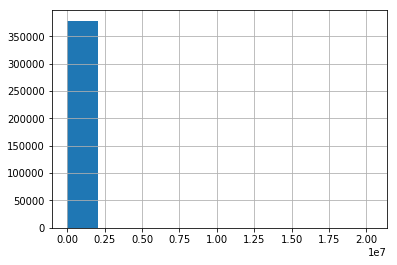

In [204]:
%matplotlib inline
kickstarter_2018.usd_pledged.hist()

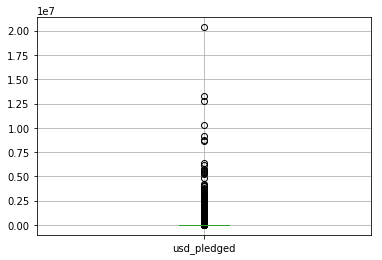

In [205]:
kickstarter_2018.boxplot(column='usd_pledged');

"There are many rules of thumb for how to define an outlier but there is no silver bullet. One rule of thumb is that any data point that is three standard deviations away from the mean of the same data point for all observations."

In [206]:
outliers = kickstarter_2018[kickstarter_2018.usd_pledged > (kickstarter_2018.usd_pledged.mean() + 
                                                            3 * kickstarter_2018.usd_pledged.std())]
outliers

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1000629643,ODIN: Android 'Smart' Projector to Carry in Yo...,Hardware,Technology,USD,2014-07-08,250000.00,2014-05-28 13:54:18,268192.00,successful,561,US,268192.00,268192.00,250000.00,0,13
1000725978,"Air Bonsai | Create your ""little star""",Product Design,Design,USD,2016-03-01,80000.00,2016-01-21 12:18:00,843743.00,successful,3784,US,843743.00,843743.00,80000.00,0,13
1001502333,Pimax: The World's First 8K VR Headset,Hardware,Technology,USD,2017-11-03,200000.00,2017-09-19 19:02:23,4236618.49,successful,5946,US,608194.00,4236618.49,200000.00,0,13
1003182869,RinseKit: The Revolutionary Portable Shower,Gadgets,Technology,USD,2016-06-03,30000.00,2016-05-04 19:27:57,396299.00,successful,2412,US,396299.00,396299.00,30000.00,0,13
1006008989,War for the Overworld,Video Games,Games,GBP,2013-01-03,150000.00,2012-11-29 19:11:23,211371.50,successful,8351,GB,338527.51,338589.87,240280.65,0,5
1008109037,The Electron: Cellular dev kit with a global d...,DIY Electronics,Technology,USD,2015-04-02,30000.00,2015-02-25 20:15:17,578478.33,successful,5564,US,578478.33,578478.33,30000.00,0,13
1008826259,"NORTH DRINKWARE : Mt. Hood, The Oregon Pint Glass",Product Design,Design,USD,2015-03-05,15000.00,2015-02-01 14:38:37,531581.00,successful,5620,US,531581.00,531581.00,15000.00,0,13
101767263,3Doodler: The World's First 3D Printing Pen,Hardware,Technology,USD,2013-03-25,30000.00,2013-02-19 06:08:59,2344134.67,successful,26457,US,2344134.67,2344134.67,30000.00,0,13
1019039281,The Apocrypha Adventure Card Game,Tabletop Games,Games,USD,2015-05-14,66666.00,2015-04-14 17:00:06,333661.99,successful,2477,US,333661.99,333661.99,66666.00,0,13


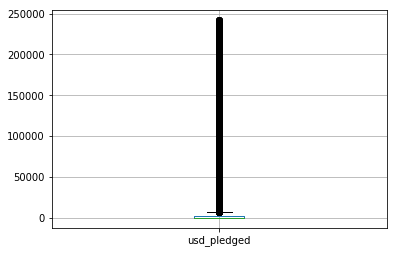

In [207]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged');

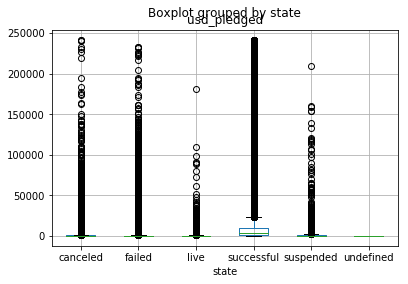

In [208]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged',by='state');

Analizar outliers por categorías

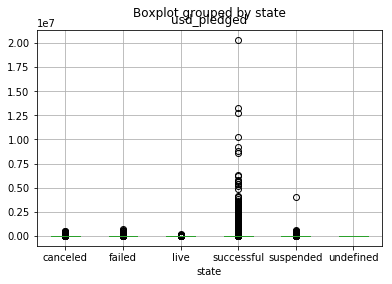

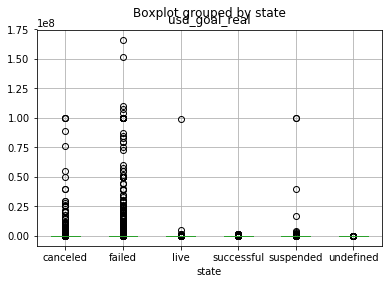

In [209]:
kickstarter_2018.boxplot(column='usd_pledged',by='state');
kickstarter_2018.boxplot(column='usd_goal_real',by='state');

#### Ejercicio 6

Calcular los valores atípicos de 'usd_goal_real' y graficar los boxplots, con y sin estos valores por categoría

In [213]:
ol_usd_goal_real = kickstarter_2018[kickstarter_2018['usd_goal_real'] > (kickstarter_2018['usd_goal_real'].mean() + 
                                                            3 * kickstarter_2018['usd_goal_real'].std())]
ol_usd_goal_real

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness,currencyencoded
ID,,,,,,,,,,,,,,,,
1009207145,** GOLIATH **,Product Design,Design,CAD,2014-07-21,3850000.00,2014-06-21 22:34:21,285.00,failed,5,CA,263.41,264.67,3575408.62,0,1
1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01,5000000.00,2015-07-07 21:14:52,0.00,failed,0,IT,0.00,0.00,5568982.99,0,4
1016210580,INDIRA – THE FIRST INDIAN GRAND MUSICAL,Musical,Theater,EUR,2016-04-27,15000000.00,2016-02-27 13:08:01,15.00,failed,6,ES,16.59,17.10,17104542.97,-1,4
1025947904,Long island city new york art book (Canceled),Photography,Photography,USD,2013-11-07,10000000.00,2013-10-08 23:16:26,0.00,canceled,0,US,0.00,0.00,10000000.00,0,13
1029500715,Harambe World's Tallest Statue,Public Art,Art,USD,2016-11-25,20000000.00,2016-09-26 18:08:01,1.00,canceled,1,US,0.00,1.00,20000000.00,0,13
1031487313,Music app ( Pupilize) is the next big thing fo...,Music,Music,USD,2017-02-07,5000000.00,2017-01-08 06:49:52,0.00,failed,0,US,0.00,0.00,5000000.00,0,13
1046235166,Duel,Science Fiction,Film & Video,USD,2016-03-06,10000000.00,2016-01-06 15:00:11,100.00,failed,2,US,100.00,100.00,10000000.00,0,13
1052555922,Cloud Based Project Analytics Dashboards,Software,Technology,USD,2017-03-05,10000000.00,2017-03-04 01:25:03,25.00,failed,1,US,25.00,25.00,10000000.00,0,13
1062809925,Turn a Blind Eye,Narrative Film,Film & Video,GBP,2014-02-21,4000000.00,2013-12-23 22:36:10,0.00,failed,0,GB,0.00,0.00,6671447.87,0,5


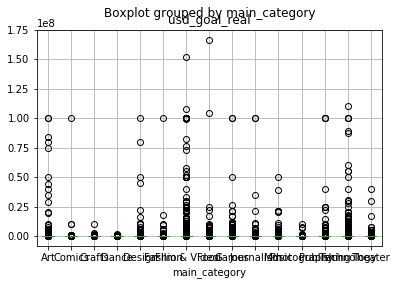

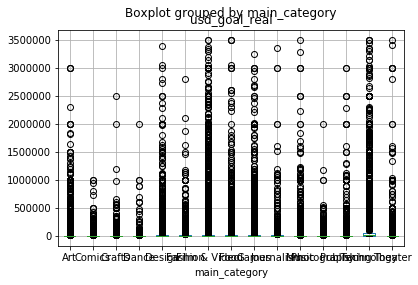

In [218]:
kickstarter_2018.boxplot(column='usd_goal_real', by="main_category")
kickstarter_2018.drop(ol_usd_goal_real.index).boxplot(column='usd_goal_real', by="main_category")

## 2.7. Evaluar cómo comprimir los datos 
para su almacenamiento más eficiente.

En la actualidad, en las nubes el almacenamiento no suele ser problema sino la velocidad para leerlo que suele ser determinante a la hora de determinar el formato de almacenamiento.


## 2.8. Guardar el set de datos con un nombre informativo.


EL problema de la ingeniería de software